Implementation: https://ethen8181.github.io/machine-learning/networkx/max_influence/max_influence.html#Cost-Effective-Lazy-Forward-(CELF)-Algorithm

In [1]:
%pip install matplotlib
%pip install scipy
%pip install community
%pip install python-louvain
%pip install python-igraph


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import community.community_louvain
import numpy as np
import matplotlib.cm as cm
import time
from igraph import Graph  # pip install python-igraph


In [32]:
from matplotlib.pyplot import figure

def print_graph(G, pos, solution): 
    figure(figsize=(12, 12), dpi=90)
    # nodes
    for n in G.nodes:
      if n in solution:
          nx.draw_networkx_nodes(G, pos, nodelist=[n], node_size=24, node_color="red")
      else:
          nx.draw_networkx_nodes(G, pos, nodelist=[n], node_size=8, node_color="blue")
    # edges
    nx.draw_networkx_edges(G, pos, width=0.5,alpha=0.2)
    plt.axis('off')
    plt.figure(figsize=(50000,50000))
    plt.show()

In [3]:
G = nx.read_edgelist("as.txt", delimiter="	")

In [6]:
###COMUNIDADES###

partition = community.community_louvain.best_partition(G)

In [7]:
nodesXcommunity = {}
for k,v in partition.items():
    if v in nodesXcommunity:
        nodesXcommunity[v] += 1
    else:
        nodesXcommunity[v] = 1
print(nodesXcommunity)

{0: 236, 1: 1395, 2: 454, 3: 892, 4: 284, 5: 294, 6: 213, 7: 156, 8: 84, 9: 281, 10: 155, 11: 106, 12: 99, 13: 334, 14: 67, 15: 71, 16: 29, 17: 51, 18: 49, 19: 97, 21: 57, 22: 207, 23: 23, 24: 31, 25: 135, 26: 122, 27: 38, 28: 50, 29: 87, 30: 197, 31: 5, 32: 64, 33: 26, 20: 85}


In [9]:
def compute_independent_cascade(graph, seed_nodes, prob, n_iters=1000):
    total_spead = 0

    # simulate the spread process over multiple runs
    for i in range(n_iters):
        np.random.seed(i)
        active = seed_nodes[:]
        new_active = seed_nodes[:]
        
        # for each newly activated nodes, find its neighbors that becomes activated
        while new_active:
            activated_nodes = []
            for node in new_active:
                neighbors = graph.neighbors(node, mode='out')
                success = np.random.uniform(0, 1, len(neighbors)) < prob
                activated_nodes += list(np.extract(success, neighbors))

            # ensure the newly activated nodes doesn't already exist
            # in the final list of activated nodes before adding them
            # to the final list
            new_active = list(set(activated_nodes) - set(active))
            active += new_active

        total_spead += len(active)

    return total_spead / n_iters

In [10]:
import heapq

def celf(graph, k, prob, n_iters=1000):
    """
    Find k nodes with the largest spread (determined by IC) from a igraph graph
    using the Cost Effective Lazy Forward Algorithm, a.k.a Lazy Greedy Algorithm.
    """
    start_time = time.time()

    # find the first node with greedy algorithm:
    # python's heap is a min-heap, thus
    # we negate the spread to get the node
    # with the maximum spread when popping from the heap
    gains = []
    for node in range(graph.vcount()):
        spread = compute_independent_cascade(graph, [node], prob, n_iters)
        heapq.heappush(gains, (-spread, node))

    # we pop the heap to get the node with the best spread,
    # when storing the spread to negate it again to store the actual spread
    spread, node = heapq.heappop(gains)
    solution = [node]
    spread = -spread
    spreads = [spread]

    # record the number of times the spread is computed
    lookups = [graph.vcount()]
    elapsed = [round(time.time() - start_time, 3)]

    for _ in range(k - 1):
        node_lookup = 0
        matched = False

        while not matched:
            node_lookup += 1

            # here we need to compute the marginal gain of adding the current node
            # to the solution, instead of just the gain, i.e. we need to subtract
            # the spread without adding the current node
            _, current_node = heapq.heappop(gains)
            spread_gain = compute_independent_cascade(
                graph, solution + [current_node], prob, n_iters) - spread

            # check if the previous top node stayed on the top after pushing
            # the marginal gain to the heap
            heapq.heappush(gains, (-spread_gain, current_node))
            matched = gains[0][1] == current_node

        # spread stores the cumulative spread
        spread_gain, node = heapq.heappop(gains)
        spread -= spread_gain
        solution.append(node)
        spreads.append(spread)
        lookups.append(node_lookup)

        elapse = round(time.time() - start_time, 3)
        elapsed.append(elapse)

    return solution, spreads, elapsed, lookups


#CALCULAMOS OUTBREAKS PARA VARIAS COMUNIDADES

## 1

In [40]:
COMUNIDAD = 11 #106 nodos
G_outbreaks3 = nx.Graph()

motifs_nodes = []
for k,v in partition.items():
    if v == COMUNIDAD:
        motifs_nodes.append(k)
G_outbreaks3.add_nodes_from(motifs_nodes)

motifs_edges = []
for e in G.edges():
    if partition[e[0]] == COMUNIDAD and partition[e[1]] == COMUNIDAD:
        motifs_edges.append(e) 
G_outbreaks3.add_edges_from(motifs_edges)

In [52]:
G_outbreaks3.nodes

NodeView(('25', '46', '47', '49', '92', '121', '134', '255', '284', '309', '316', '328', '359', '366', '1104', '1105', '1187', '1200', '1271', '1361', '1431', '1468', '1497', '1521', '1523', '1532', '1586', '1634', '1665', '1800', '1803', '1907', '1949', '1980', '2079', '2168', '3215', '3893', '3971', '4030', '4037', '4038', '2552', '4380', '4540', '694', '4939', '5804', '5989', '2588', '2711', '2712', '2887', '2904', '4387', '3660', '3721', '3733', '5625', '5735', '6447', '645', '695', '705', '760', '806', '2399', '4372', '4373', '4375', '4376', '4377', '4381', '4382', '4383', '4384', '4389', '4390', '4392', '4396', '3449', '5241', '5282', '5805', '5806', '5807', '4938', '4940', '3772', '5751', '5654', '6158', '4059', '5634', '6160', '6410', '5305', '6153', '6154', '6155', '6156', '6157', '6159', '6473', '5306', '6472'))

In [42]:
graph3 = Graph()
graph3.add_vertices(list(G_outbreaks3.nodes))
graph3.add_edges(list(G_outbreaks3.edges))


In [49]:
k = 3
prob = 0.2
n_iters = 1000

celf_solution2, celf_spreads2, celf_elapsed2, celf_lookups2 = celf(graph3, k, prob, n_iters)
print('solution: ', celf_solution2)
print('spreads: ', celf_spreads2)
print('elapsed: ', celf_elapsed2)
print('lookups: ', celf_lookups2)

solution:  [2, 37, 3]
spreads:  [12.856, 15.946, 19.041]
elapsed:  [6.802, 20.478, 20.847]
lookups:  [106, 50, 1]


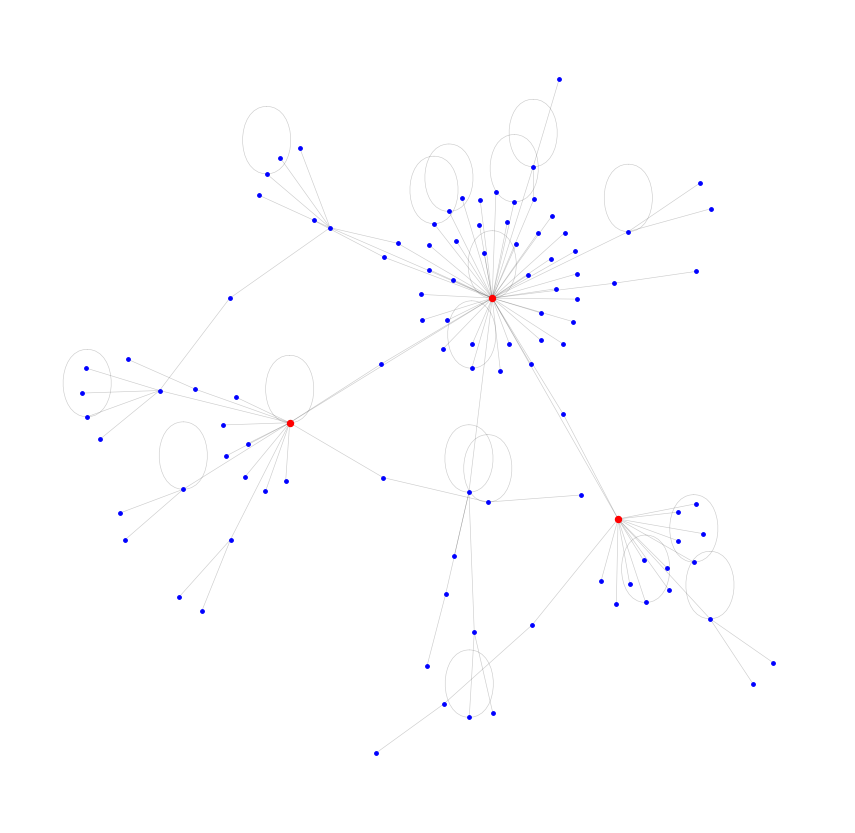

<Figure size 3.6e+06x3.6e+06 with 0 Axes>

In [51]:
nodos2 = (list(G_outbreaks3.nodes))
outs2 = [nodos2[2], nodos2[37], nodos2[3]]
print_graph(G_outbreaks3, nx.spring_layout(G_outbreaks3), outs2)

In [70]:
outs2

['47', '3893', '49']

## 2

In [59]:

COMUNIDAD = 2 #454 nodos
G_outbreaks4 = nx.Graph()

motifs_nodes = []
for k,v in partition.items():
    if v == COMUNIDAD:
        motifs_nodes.append(k)
G_outbreaks4.add_nodes_from(motifs_nodes)

motifs_edges = []
for e in G.edges():
    if partition[e[0]] == COMUNIDAD and partition[e[1]] == COMUNIDAD:
        motifs_edges.append(e) 
G_outbreaks4.add_edges_from(motifs_edges)

In [60]:
G_outbreaks4.nodes

NodeView(('2', '3', '21', '26', '30', '33', '34', '37', '44', '45', '63', '86', '93', '126', '127', '138', '173', '180', '181', '184', '188', '191', '195', '196', '199', '217', '222', '224', '230', '238', '251', '269', '275', '301', '332', '335', '338', '367', '371', '377', '417', '441', '445', '678', '716', '833', '872', '922', '931', '944', '1068', '1113', '1122', '1127', '1128', '1130', '1162', '1163', '1192', '1201', '1209', '1262', '1291', '1294', '1296', '1299', '1307', '1310', '1311', '1317', '1320', '1340', '1342', '1353', '1372', '1382', '1386', '1406', '1410', '1412', '1427', '1442', '1466', '1469', '1479', '1482', '1489', '1504', '1509', '1530', '1543', '1551', '1554', '1555', '1577', '1584', '1585', '1592', '1606', '1623', '1639', '1640', '1642', '1644', '1645', '1656', '1663', '1675', '1679', '1680', '1681', '1682', '1693', '1694', '1696', '1703', '1706', '1711', '1743', '1745', '1766', '1777', '1783', '1787', '1796', '1801', '1814', '1849', '1850', '1854', '1861', '1865',

In [63]:
nodes = list(G_outbreaks4.nodes)
edges = list(G_outbreaks4.edges)
graph4 = Graph()
graph4.add_vertices(nodes)
graph4.add_edges(edges)


In [65]:
k = 3
prob = 0.2
n_iters = 1000

celf_solution4, celf_spreads4, celf_elapsed4, celf_lookups4 = celf(graph4, k, prob, n_iters)
print('solution: ', celf_solution4)
print('spreads: ', celf_spreads4)
print('elapsed: ', celf_elapsed4)
print('lookups: ', celf_lookups4)

solution:  [0, 3, 6]
spreads:  [76.709, 83.94, 88.092]
elapsed:  [145.071, 744.002, 822.989]
lookups:  [454, 392, 47]


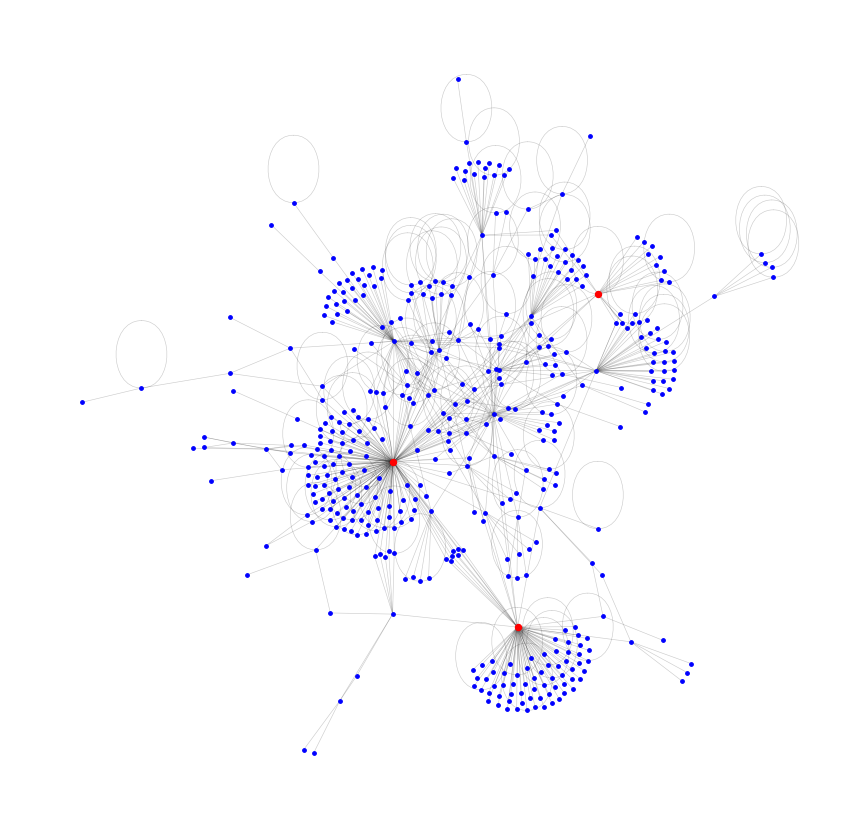

<Figure size 3.6e+06x3.6e+06 with 0 Axes>

In [66]:
nodos = (list(G_outbreaks4.nodes))
outs = [nodos[0], nodos[3], nodos[6]]
print_graph(G_outbreaks4, nx.spring_layout(G_outbreaks4), outs)

In [67]:
outs

['2', '26', '34']

## 3

In [11]:

COMUNIDAD = 3 #892 nodos
G_outbreaks = nx.Graph()

motifs_nodes = []
for k,v in partition.items():
    if v == COMUNIDAD:
        motifs_nodes.append(k)
G_outbreaks.add_nodes_from(motifs_nodes)

motifs_edges = []
for e in G.edges():
    if partition[e[0]] == COMUNIDAD and partition[e[1]] == COMUNIDAD:
        motifs_edges.append(e) 
G_outbreaks.add_edges_from(motifs_edges)

In [37]:
G_outbreaks.nodes

NodeView(('4', '10', '43', '54', '58', '59', '62', '64', '65', '66', '67', '68', '129', '132', '200', '219', '241', '242', '243', '247', '248', '253', '459', '475', '551', '600', '941', '1112', '1114', '1119', '1120', '1389', '1481', '1515', '1534', '1550', '1560', '1564', '1733', '2146', '2148', '2149', '579', '901', '902', '3254', '907', '3892', '552', '856', '857', '859', '861', '862', '863', '866', '867', '868', '869', '870', '873', '876', '877', '879', '880', '881', '882', '883', '884', '886', '888', '889', '890', '891', '892', '893', '894', '895', '469', '817', '900', '2193', '2194', '3269', '3475', '3921', '4219', '4581', '4582', '4607', '3192', '4229', '4362', '2592', '2688', '2693', '2819', '2197', '2203', '2928', '2930', '2931', '3278', '3333', '3334', '3253', '4231', '550', '796', '3822', '4145', '4330', '4881', '3202', '3220', '386', '2187', '2293', '3068', '3275', '3370', '4334', '5100', '5343', '5386', '5522', '5786', '2282', '2213', '2220', '3365', '4332', '4339', '5332'

In [12]:
nodes = list(G_outbreaks.nodes)
edges = list(G_outbreaks.edges)
graph = Graph()
graph.add_vertices(nodes)
graph.add_edges(edges)


In [16]:
k = 3
prob = 0.2
n_iters = 1000

celf_solution, celf_spreads, celf_elapsed, celf_lookups = celf(graph, k, prob, n_iters)
print('solution: ', celf_solution)
print('spreads: ', celf_spreads)
print('elapsed: ', celf_elapsed)
print('lookups: ', celf_lookups)

solution:  [24, 638, 678]
spreads:  [245.54, 247.416, 249.391]
elapsed:  [1274.216, 5681.076, 5700.704]
lookups:  [892, 892, 4]


In [68]:
nodos = (list(G_outbreaks.nodes))
outs = [nodos[24], nodos[638], nodos[678]]


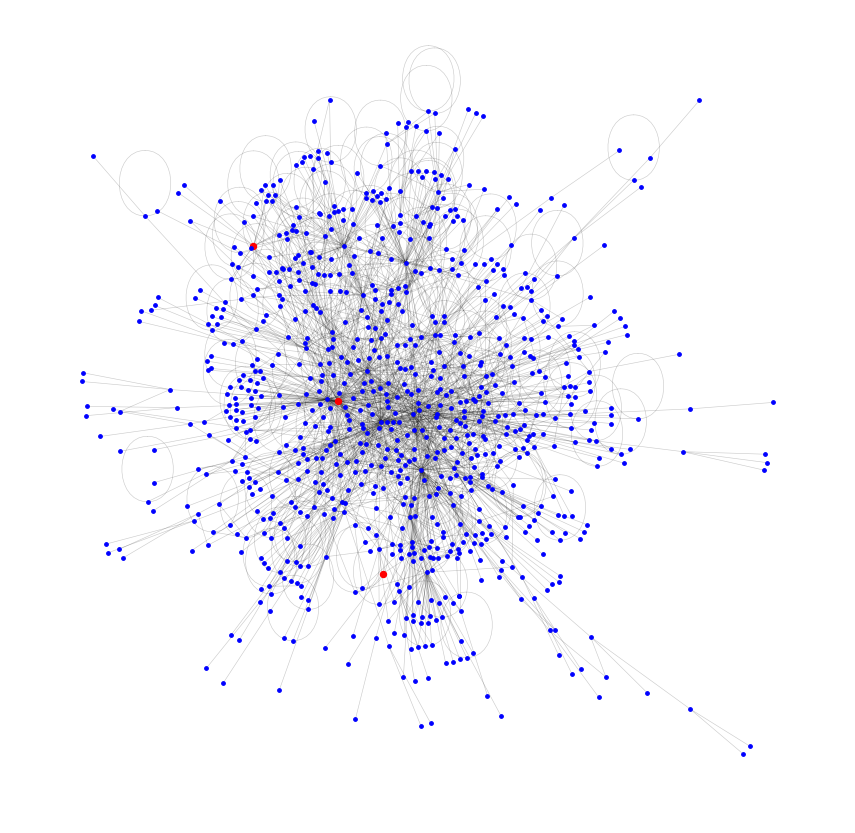

<Figure size 3.6e+06x3.6e+06 with 0 Axes>

In [33]:
print_graph(G_outbreaks, nx.spring_layout(G_outbreaks), outs)

In [69]:
outs

['551', '3350', '5873']

## 4 

In [ ]:
COMUNIDAD = 1 #1264 nodos
G_outbreaks2 = nx.Graph()

motifs_nodes = []
for k,v in partition.items():
    if v == COMUNIDAD:
        motifs_nodes.append(k)
G_outbreaks2.add_nodes_from(motifs_nodes)

motifs_edges = []
for e in G.edges():
    if partition[e[0]] == COMUNIDAD and partition[e[1]] == COMUNIDAD:
        motifs_edges.append(e) 
G_outbreaks2.add_edges_from(motifs_edges)

In [ ]:
G_outbreaks2.nodes

NodeView(('1', '6', '7', '9', '22', '35', '51', '70', '74', '81', '89', '90', '105', '121', '123', '131', '146', '177', '218', '220', '231', '235', '261', '282', '289', '302', '331', '337', '341', '352', '368', '372', '430', '454', '499', '553', '554', '555', '556', '567', '568', '569', '571', '572', '573', '575', '581', '587', '588', '590', '591', '599', '606', '607', '608', '609', '612', '613', '635', '673', '696', '899', '997', '1029', '1057', '1058', '1060', '1062', '1063', '1064', '1065', '1067', '1069', '1070', '1071', '1072', '1073', '1075', '1076', '1077', '1078', '1080', '1081', '1082', '1084', '1085', '1088', '1089', '1093', '1094', '1095', '1096', '1099', '1100', '1101', '1102', '1106', '1110', '1123', '1124', '1125', '1126', '1129', '1131', '1132', '1133', '1134', '1135', '1136', '1138', '1140', '1141', '1143', '1144', '1145', '1147', '1148', '1149', '1150', '1151', '1152', '1153', '1154', '1156', '1157', '1158', '1159', '1160', '1161', '1164', '1167', '1168', '1169', '1170

In [ ]:
nodes = list(G_outbreaks2.nodes)
edges = list(G_outbreaks2.edges)

In [ ]:
graph2 = Graph()
graph2.add_vertices(nodes)
graph2.add_edges(edges)


In [ ]:
k = 2
prob = 0.2
n_iters = 1000

celf_solution, celf_spreads, celf_elapsed, celf_lookups = celf(graph2, k, prob, n_iters)
print('solution: ', celf_solution)
print('spreads: ', celf_spreads)
print('elapsed: ', celf_elapsed)
print('lookups: ', celf_lookups)

solution:  [1, 1256]
spreads:  [363.482, 365.236]
elapsed:  [2676.545, 11575.526]
lookups:  [1264, 1264]


solution:  [1, 1256]
spreads:  [363.482, 365.236]
elapsed:  [2676.545, 11575.526]
lookups:  [1264, 1264]


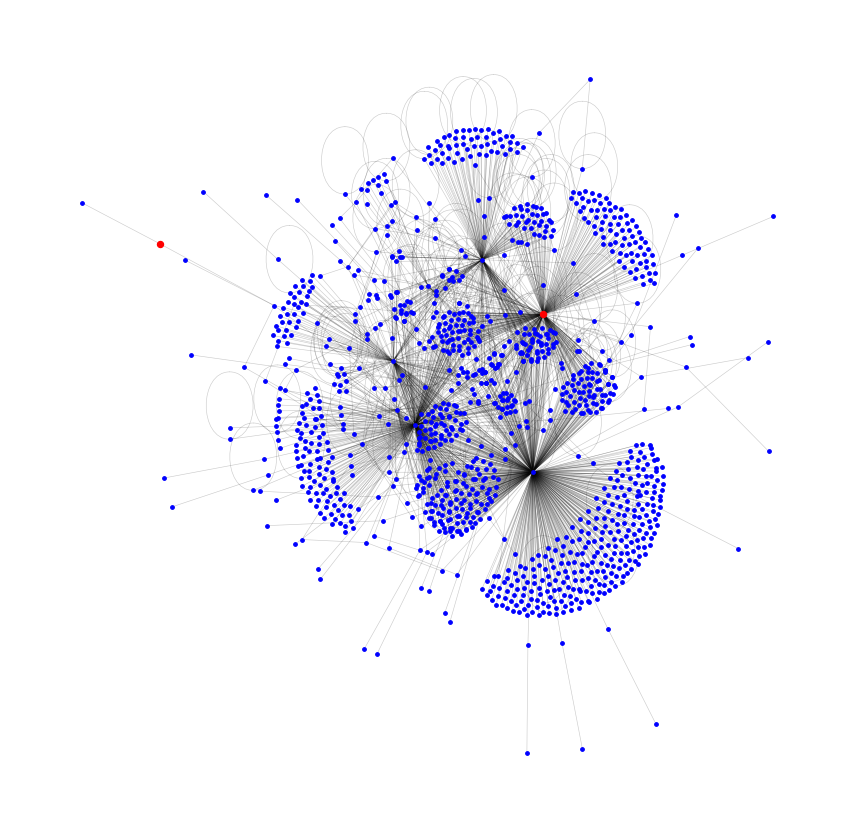

<Figure size 3.6e+06x3.6e+06 with 0 Axes>

In [71]:
nodos = (list(G_outbreaks2.nodes))
outs = [nodos[1], nodos[1256]]
print_graph(G_outbreaks2, nx.spring_layout(G_outbreaks2), outs)

In [72]:
outs

['6', '3103']